### 3.1. Dự báo điểm trung bình năm 2026 theo môn

#### 3.1.1. Mục tiêu

- Xây dựng mô hình dự báo **điểm trung bình** các môn thi chính (Toán, Ngữ văn, Ngoại ngữ, các môn tổ hợp) cho năm 2026.
- Xem xét tác động của **“điểm gãy 2025”** lên quỹ đạo điểm trung bình theo thời gian.
- So sánh nhiều mô hình (baseline tuyến tính, mô hình ML/Time-series) và chọn ra kịch bản dự báo hợp lý.

#### 3.1.2. Chuẩn bị dữ liệu chuỗi theo môn

- Dữ liệu đầu vào: bảng tổng hợp theo **năm–môn** với các cột:
  - `year` (hoặc `nam_hoc`), `subject`,
  - `mean_score`, `median_score`, `std`,
  - `n_students`, cùng một số chỉ báo (tỉ lệ ≥5, ≥8 nếu có).
- Mỗi môn tạo một chuỗi thời gian ngắn 2023–2025:
  \[
    \{\text{mean\_score}_{2023}, \text{mean\_score}_{2024}, \text{mean\_score}_{2025}\}
  \]
- Tạo thêm các đặc trưng:
  - `year_idx` (mã hoá thời gian),
  - `delta_mean = mean_t - mean_{t-1}`,
  - `post_2025` (0 cho 2023–2024, 1 cho 2025 trở đi)  
    để mô hình nhận biết 2025 là điểm gãy.

#### 3.1.3. Các mô hình dự báo điểm trung bình

(Cụ thể điền đúng theo các mô hình đã implement trong Notebook)

- **Baseline tuyến tính**:
  - Hồi quy tuyến tính đơn giản theo `year_idx` cho từng môn.
- **Mô hình ML / Time-series**:
  - Ví dụ: Random Forest / Gradient Boosting trên bảng đặc trưng,
  - hoặc ARIMA/Prophet riêng cho từng chuỗi môn.
- Các mô hình được huấn luyện trên dữ liệu năm 2023–2025
  (hoặc thêm 2018–2022 nếu có dữ liệu lịch sử cùng chương trình).

#### 3.1.4. Chiến lược đánh giá

- Sử dụng **backtest theo thời gian**:
  - Train trên 2023, dự báo 2024 → tính sai số.
  - Train trên 2023–2024, dự báo 2025 → tính sai số.
- Chỉ số đánh giá: MAE / RMSE giữa điểm trung bình dự báo và thực tế theo từng môn.
- Chọn mô hình có sai số thấp và đường dự báo hợp lý (không quá “gãy khúc” so với bối cảnh đổi mới đề thi).

#### 3.1.5. Quy trình dự báo điểm trung bình năm 2026

- Dùng mô hình tốt nhất để:
  - Huấn luyện trên toàn bộ chuỗi hiện có (trước 2026).
  - Dự báo `mean_score_2026` cho từng môn.
- Nếu 2025 là điểm gãy mạnh:
  - Có thể tách riêng **regime sau 2025** hoặc dùng feature `post_2025`
    để mô hình không kéo trend 2018–2024 một cách máy móc.
- Thu được bảng:
  \[
    \texttt{subject, year, mean\_actual, mean\_predicted}
  \]
  trong đó:
  - `mean_actual` có cho 2023–2025,
  - `mean_predicted` có cho 2026.

#### 3.1.6. Trực quan hoá và diễn giải

- Vẽ biểu đồ line theo từng môn:
  - Đường thực tế 2023–2025,
  - Điểm/đoạn dự báo 2026 (kèm khoảng tin cậy nếu có).
- Nhận xét:
  - Môn nào dự kiến giảm / tăng sau khi đổi chương trình (so với 2025),
  - Môn nào giữ xu hướng ổn định.

#### 3.1.7. Hạn chế và hướng mở rộng

- Chuỗi thời gian ngắn → khó mô hình hoá trend dài hạn.
- Dự báo 2026 chịu ảnh hưởng mạnh từ giả định về **tính ổn định của regime mới sau 2025**.
- Hướng phát triển:
  - Bổ sung thêm dữ liệu các năm tiếp theo,
  - Kết hợp thêm thông tin về chính sách, cấu trúc đề thi, phân bố tổ hợp… vào mô hình.


# Forecast

In [1]:
import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error

In [2]:
import sys
import os

# 1. Lấy đường dẫn của thư mục 'Notebook'
current_dir = os.getcwd() 

# 2. Lấy đường dẫn của thư mục Project_Root (Thư mục cha của 'Notebook' và 'Module')
# Đây là thư mục Project_Root/
project_root_dir = os.path.dirname(current_dir)

# 3. Thêm Project_Root vào sys.path
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)
    
print(f"Đã thêm đường dẫn gốc: {project_root_dir}")

# Lệnh import này sẽ hoạt động sau khi thêm Project_Root vào sys.path
from Module.Load_Data import DataLoader, CleanDataLoader
from Module.Processor_Data import DataProcessor

Đã thêm đường dẫn gốc: c:\Users\Admin\OneDrive\Máy tính\Code\Project Python for Data\PythonProject


1) Dự báo điểm theo môn

In [3]:
# Xây dựng Map chọn môn học
subject_map = {
    1: "toan",
    2: "ngu_van",
    3: "vat_li",
    4: "hoa_hoc",
    5: "sinh_hoc",
    6: "tin_hoc",
    7: "cn_cong_nghiep",
    8: "cn_nong_nghiep",
    9: "lich_su",
    10: "dia_li",
    11: "gdcd",
    12: "ngoai_ngu",
}

print("=== Danh sách môn học ===")
for k, v in subject_map.items():
    print(f"{k}: {v}")



=== Danh sách môn học ===
1: toan
2: ngu_van
3: vat_li
4: hoa_hoc
5: sinh_hoc
6: tin_hoc
7: cn_cong_nghiep
8: cn_nong_nghiep
9: lich_su
10: dia_li
11: gdcd
12: ngoai_ngu


In [4]:
# Load cleaned data: 
clean_data = CleanDataLoader() 

In [5]:
# Lấy dữ liệu phân phối và phân tích cho từng môn học
dist_list = []
analysis_list = []

for choice, subject in subject_map.items():

    # ----- DISTRIBUTION -----
    df_dist = clean_data.get_subject_data(
        subject=subject,
        kind="distribution"
    )

    if df_dist is not None and not df_dist.empty:

        # Chuẩn hoá cột môn học
        if "mon_hoc" in df_dist.columns:
            df_dist = df_dist.rename(columns={"mon_hoc": "subject"})
        else:
            df_dist["subject"] = subject

        # Phòng trường hợp vẫn còn 2 cột
        df_dist = df_dist.loc[:, ~df_dist.columns.duplicated()]

        dist_list.append(df_dist)

    # ----- ANALYSIS -----
    df_anal = clean_data.get_subject_data(
        subject=subject,
        kind="analysis"
    )

    if df_anal is not None and not df_anal.empty:

        if "mon_hoc" in df_anal.columns:
            df_anal = df_anal.rename(columns={"mon_hoc": "subject"})
        else:
            df_anal["subject"] = subject

        df_anal = df_anal.loc[:, ~df_anal.columns.duplicated()]

        analysis_list.append(df_anal)

# ----- CONCAT -----
df_distribution = pd.concat(dist_list, ignore_index=True)
df_analysis = pd.concat(analysis_list, ignore_index=True)

print(df_distribution.head() ,"\n")
print(df_analysis.head())

   nam_hoc subject  diem  so_hoc_sinh
0     2023    toan   0.0            2
1     2023    toan   0.2            1
2     2023    toan   0.4            2
3     2023    toan   0.6            4
4     2023    toan   0.8           32 

   nam_hoc      mean  median  mode       std  min   max  subject
0     2023  6.250557     6.6  7.60  1.633336  0.0  10.0     toan
1     2024  6.447309     6.8  7.60  1.556900  0.0   9.8     toan
2     2025  4.799712     4.6  4.75  1.688549  0.0  10.0     toan
3     2023  6.858194     7.0  7.00  1.326471  0.0  10.0  ngu_van
4     2024  7.231146     7.5  8.00  1.330057  0.0  10.0  ngu_van


In [6]:
n_students_df = (
    df_distribution
    .groupby("nam_hoc")["so_hoc_sinh"]
    .sum()
    .reset_index(name="n_students")
) # Tổng số học sinh theo năm học

summary_df = df_analysis.merge(
    n_students_df,
    on="nam_hoc",
    how="left"
) # Tạo dataframe tổng hợp với số học sinh

summary_df_std = summary_df.copy()
summary_df_std = summary_df_std.rename(columns={
    "nam_hoc": "year",
    "mean": "mean_score",
    "median": "median_score"
}) # Chuẩn hoá tên cột

summary_df_std = summary_df_std[
    ["year", "subject", "mean_score", "median_score", "std", "n_students"]
] # Chuẩn hoá dataframe

print(summary_df_std.head())

   year  subject  mean_score  median_score       std  n_students
0  2023     toan    6.250557           6.6  1.633336     5803574
1  2024     toan    6.447309           6.8  1.556900     6037435
2  2025     toan    4.799712           4.6  1.688549     4579308
3  2023  ngu_van    6.858194           7.0  1.326471     5803574
4  2024  ngu_van    7.231146           7.5  1.330057     6037435


In [7]:
# Xây dựng series_dict cho mô hình ARIMAX với biến giả break tại 2025
df = summary_df_std.copy()
df["post_2025"] = (df["year"] >= 2025).astype(int)

df = df.sort_values(["subject", "year"])

series_dict = {}

for subject, g in df.groupby("subject"):
    g = g.sort_values("year")
    
    y = g.set_index("year")["mean_score"]
    exog = g.set_index("year")[["post_2025"]]
    
    series_dict[subject] = {
        "y": y,
        "exog": exog
    }

In [8]:
# Hàm xây dựng dataframe dựa trên feature cho mô hình RF và XGB
def build_ml_df(df, df_rates=None):
    df = df.sort_values(["subject", "year"]).copy()

    df["post_2025"] = (df["year"] >= 2025).astype(int)

    df["delta_score"] = (
        df.groupby("subject")["mean_score"]
          .diff()
          .fillna(0)
    )

    df["mean_prev"] = (
        df.groupby("subject")["mean_score"]
          .transform(lambda x: x.shift().expanding().mean())
    )

    df["is_first_year"] = (df.groupby("subject").cumcount() == 0).astype(int)

    df["mean_prev"] = (
        df["mean_prev"]
        .fillna(0)
    )

    # ===== merge tỉ lệ nếu có =====
    if df_rates is not None:
        df = df.merge(df_rates, on=["year", "subject"], how="left")
        df[["rate_ge_5", "rate_ge_8"]] = df[["rate_ge_5", "rate_ge_8"]].fillna(0)

    return df

In [9]:
# 1. Chuẩn hóa distribution dataframe
df_dist_std = df_distribution.rename(columns={
    "nam_hoc": "year",
    "diem": "score",
    "so_hoc_sinh": "count"
})

# 2. Tổng số thí sinh
total_students = (
    df_dist_std
    .groupby(["year", "subject"], as_index=False)["count"]
    .sum()
    .rename(columns={"count": "n_students"})
)

# 3. Số thí sinh ≥ 5
ge_5 = (
    df_dist_std[df_dist_std["score"] >= 5]
    .groupby(["year", "subject"], as_index=False)["count"]
    .sum()
    .rename(columns={"count": "n_ge_5"})
)

# 4. Số thí sinh ≥ 8
ge_8 = (
    df_dist_std[df_dist_std["score"] >= 8]
    .groupby(["year", "subject"], as_index=False)["count"]
    .sum()
    .rename(columns={"count": "n_ge_8"})
)

# ===== 5. Gộp các bảng =====
df_rates = (
    total_students
    .merge(ge_5, on=["year", "subject"], how="left")
    .merge(ge_8, on=["year", "subject"], how="left")
)

# ===== 6. Fill missing (nếu không có ai ≥5 hoặc ≥8) =====
df_rates[["n_ge_5", "n_ge_8"]] = df_rates[["n_ge_5", "n_ge_8"]].fillna(0)

# ===== 7. Tính tỉ lệ =====
df_rates["rate_ge_5"] = df_rates["n_ge_5"] / df_rates["n_students"]
df_rates["rate_ge_8"] = df_rates["n_ge_8"] / df_rates["n_students"]

df_rates = df_rates[[
    "year", "subject", "rate_ge_5", "rate_ge_8"
]]

ml_df = build_ml_df(summary_df_std, df_rates)
print(ml_df.head())

   year         subject  mean_score  median_score       std  n_students  \
0  2025  cn_cong_nghiep    5.792555          5.60  1.539870     4579308   
1  2025  cn_nong_nghiep    7.715897          7.75  1.170514     4579308   
2  2023          dia_li    6.147523          6.25  1.168732     5803574   
3  2024          dia_li    7.193541          7.25  1.283945     6037435   
4  2025          dia_li    6.642910          6.75  1.750127     4579308   

   post_2025  delta_score  mean_prev  is_first_year  rate_ge_5  rate_ge_8  
0          1     0.000000   0.000000              1   0.659389   0.112227  
1          1     0.000000   0.000000              1   0.978547   0.487981  
2          0     0.000000   0.000000              1   0.866488   0.066412  
3          0     1.046018   6.147523              0   0.956368   0.310090  
4          1    -0.550631   6.670532              0   0.815334   0.270256  


In [10]:
def regression_metrics_for_AR(y_true, y_pred): # Lấy giá trị MAE, RMSE, MAPE cho AR và ARIMAX
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape}

def forecast_arima(y_train, steps=1, exog_train=None, exog_test=None, use_exog=False):
    """
    Forecast AR hoặc ARIMAX model.
    y_train: pd.Series
    exog_train/exog_test: pd.DataFrame
    steps: int, số bước dự báo
    use_exog: bool
    """
    # Nếu y_train quá ngắn (1 điểm), fallback: dự báo = last observed
    if len(y_train) < 2:
        return np.repeat(y_train.iloc[-1], steps)

    # Ép y_train thành 1D array
    y_train_arr = np.array(y_train).ravel()

    if use_exog and exog_train is not None:
        # Ép exog train/test thành 2D array (n_samples, n_features)
        exog_train_arr = np.array(exog_train).reshape(-1, exog_train.shape[1])
        exog_test_arr  = np.array(exog_test).reshape(-1, exog_test.shape[1])
        model = ARIMA(y_train_arr, exog=exog_train_arr, order=(1,0,0))
        res = model.fit()
        pred = res.forecast(steps=steps, exog=exog_test_arr)
    else:
        model = ARIMA(y_train_arr, order=(1,0,0))
        res = model.fit()
        pred = res.forecast(steps=steps)

    # Trả về 1D array
    return np.array(pred).ravel()

In [11]:
metrics_list = []

for subject, data in series_dict.items():
    y = data["y"]
    exog = data["exog"]

    # ---------------- Backtest A: 2023 → 2024 ----------------
    if 2023 in y.index and 2024 in y.index:
        y_train_A = y.loc[2023:2023]
        y_test_A  = y.loc[2024:2024]
        exog_train_A = exog.loc[2023:2023] if exog is not None else None
        exog_test_A  = exog.loc[2024:2024] if exog is not None else None

        # AR (không post_2025)
        pred_AR = forecast_arima(y_train_A, steps=len(y_test_A))
        metrics_list.append({
            "subject": subject,
            "model": "AR_no_break",
            "train_period": "2023",
            "test_year": 2024,
            **regression_metrics_for_AR(y_test_A, pred_AR)
        })

        # ARIMAX (có post_2025)
        if exog_train_A is not None:
            pred_ARIMAX = forecast_arima(
                y_train_A,
                steps=len(y_test_A),
                exog_train=exog_train_A,
                exog_test=exog_test_A,
                use_exog=True
            )

            metrics_list.append({
                "subject": subject,
                "model": "ARIMAX_break",
                "train_period": "2023",
                "test_year": 2024,
                **regression_metrics_for_AR(y_test_A, pred_ARIMAX)
            })

    # ---------------- Backtest B: 2023–2024 → 2025 ----------------
    if 2023 in y.index and 2024 in y.index and 2025 in y.index:
        y_train_B = y.loc[2023:2024]
        y_test_B  = y.loc[2025:2025]
        exog_train_B = exog.loc[2023:2024] if exog is not None else None
        exog_test_B  = exog.loc[2025:2025] if exog is not None else None

        # AR
        pred_AR = forecast_arima(y_train_B, steps=len(y_test_B))
        metrics_list.append({
            "subject": subject,
            "model": "AR_no_break",
            "train_period": "2023-2024",
            "test_year": 2025,
            **regression_metrics_for_AR(y_test_B, pred_AR)
        })

        # ARIMAX
        if exog_train_B is not None:
            pred_ARIMAX = forecast_arima(
                y_train_B,
                steps=len(y_test_B),
                exog_train=exog_train_B,
                exog_test=exog_test_B,
                use_exog=True
            )
            metrics_list.append({
                "subject": subject,
                "model": "ARIMAX_break",
                "train_period": "2023-2024",
                "test_year": 2025,
                **regression_metrics_for_AR(y_test_B, pred_ARIMAX)
            })

# Tạo DataFrame
df_ar_metrics = pd.DataFrame(metrics_list)

ar_metrics_overall = (
    df_ar_metrics
    .groupby("model", as_index=False)
    .agg({
        "MAE": "mean",
        "RMSE": "mean",
        "MAPE": "mean"
    })
) 

df_only_ar = df_ar_metrics[
    df_ar_metrics["model"].isin(["AR_no_break"])
].reset_index(drop=True) # dùng để so sánh mô hình theo từng môn học

print(df_only_ar[["model", "subject", "train_period", "test_year", "MAE", "RMSE", "MAPE"]])

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters foun

          model    subject train_period  test_year       MAE      RMSE  \
0   AR_no_break     dia_li         2023       2024  1.046018  1.046018   
1   AR_no_break     dia_li    2023-2024       2025  0.495387  0.495387   
2   AR_no_break       gdcd         2023       2024  0.129301  0.129301   
3   AR_no_break       gdcd    2023-2024       2025  0.594285  0.594285   
4   AR_no_break    hoa_hoc         2023       2024  0.063816  0.063816   
5   AR_no_break    hoa_hoc    2023-2024       2025  0.674861  0.674861   
6   AR_no_break    lich_su         2023       2024  0.544714  0.544714   
7   AR_no_break    lich_su    2023-2024       2025  0.489300  0.489300   
8   AR_no_break  ngoai_ngu         2023       2024  0.059528  0.059528   
9   AR_no_break  ngoai_ngu    2023-2024       2025  0.056062  0.056062   
10  AR_no_break    ngu_van         2023       2024  0.372952  0.372952   
11  AR_no_break    ngu_van    2023-2024       2025  0.132289  0.132289   
12  AR_no_break   sinh_hoc         202

In [12]:
subject_dummies = pd.get_dummies(ml_df["subject"], prefix="subject") #One-hot encode cột subject
ml_df = pd.concat([ml_df, subject_dummies], axis=1)

# Backtest 23 -> 24
train_A = ml_df[ml_df.year == 2023] 
test_A  = ml_df[ml_df.year == 2024]

# Backtest 23-24 -> 25
train_B = ml_df[ml_df.year <= 2024]
test_B  = ml_df[ml_df.year == 2025]

base_features = [
    "year",
    "mean_prev",
    "delta_score",
    "is_first_year",
    "rate_ge_5",
    "rate_ge_8"
] # Các feature cơ bản

features_no_break = base_features + [
    c for c in ml_df.columns if c.startswith("subject_")
] # Features cho mô hình không có break

features_break = features_no_break + ["post_2025"] # Features cho mô hình có break

In [13]:
def regression_metrics(y_true, y_pred): #Lấy giá trị MAE, RMSE, MAPE cho FR và XGB
    return pd.Series({
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": root_mean_squared_error(y_true, y_pred),
        "MAPE": mean_absolute_percentage_error(y_true, y_pred) 
    })

def evaluate_by_subject(df_eval):
    """
    df_eval phải có các cột:
    subject, year, mean_score, y_pred
    (đã gộp nhiều backtest)
    """
    rows = []

    for subject in df_eval["subject"].unique():
        g = df_eval[df_eval["subject"] == subject]

        metrics = regression_metrics(
            g["mean_score"],
            g["y_pred"]
        )

        metrics["subject"] = subject
        rows.append(metrics)

    return pd.DataFrame(rows)

In [14]:
all_preds_rf = []
# ================= BACKTEST A =================

# ----- RF_no_break -----
rf_A_no = RandomForestRegressor(
    n_estimators=500,
    max_depth=6,
    min_samples_leaf=2,
    random_state=42
)

rf_A_no.fit(train_A[features_no_break], train_A["mean_score"])
y_pred_A_no = rf_A_no.predict(test_A[features_no_break])

tmp_A_no = test_A[["subject", "year", "mean_score"]].copy()
tmp_A_no["y_pred"] = y_pred_A_no
tmp_A_no["model"] = "RF_no_break"
all_preds_rf.append(tmp_A_no)


# ----- RF_break (post_2025 = 1 → sanity check) -----
rf_A_br = RandomForestRegressor(
    n_estimators=500,
    max_depth=6,
    min_samples_leaf=2,
    random_state=42
)

rf_A_br.fit(train_A[features_break], train_A["mean_score"])
y_pred_A_br = rf_A_br.predict(test_A[features_break])

tmp_A_br = test_A[["subject", "year", "mean_score"]].copy()
tmp_A_br["y_pred"] = y_pred_A_br
tmp_A_br["model"] = "RF_break"
all_preds_rf.append(tmp_A_br)

# ================= BACKTEST B =================

# ----- RF_no_break -----
rf_B_no = RandomForestRegressor(
    n_estimators=500,
    max_depth=6,
    min_samples_leaf=2,
    random_state=42
)

rf_B_no.fit(train_B[features_no_break], train_B["mean_score"])
y_pred_B_no = rf_B_no.predict(test_B[features_no_break])

tmp_B_no = test_B[["subject", "year", "mean_score"]].copy()
tmp_B_no["y_pred"] = y_pred_B_no
tmp_B_no["model"] = "RF_no_break"
all_preds_rf.append(tmp_B_no)


# ----- RF_break -----
rf_B_br = RandomForestRegressor(
    n_estimators=500,
    max_depth=6,
    min_samples_leaf=2,
    random_state=42
)

rf_B_br.fit(train_B[features_break], train_B["mean_score"])
y_pred_B_br = rf_B_br.predict(test_B[features_break])

tmp_B_br = test_B[["subject", "year", "mean_score"]].copy()
tmp_B_br["y_pred"] = y_pred_B_br
tmp_B_br["model"] = "RF_break"
all_preds_rf.append(tmp_B_br)

In [15]:
df_eval_rf = pd.concat(all_preds_rf, ignore_index=True)

rf_metrics_overall = (
    df_eval_rf
    .groupby("model")
    .apply(lambda g: regression_metrics(
        g["mean_score"],
        g["y_pred"]
    ))
    .reset_index()
) # dùng cho đánh giá kịch bản có hay không có break(post_2025)

rf_metrics_by_subject = (
    df_eval_rf[df_eval_rf.model == "RF_no_break"]
    .groupby("subject")
    .apply(lambda g: regression_metrics(
        g["mean_score"],
        g["y_pred"]
    ))
    .reset_index()
) # dùng để so sánh mô hình theo từng môn học

rf_metrics_by_subject["model"] = "RF_no_break"

C:\Users\Admin\AppData\Local\Temp\ipykernel_13792\914396385.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: regression_metrics(
C:\Users\Admin\AppData\Local\Temp\ipykernel_13792\914396385.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: regression_metrics(


In [16]:
all_preds_xgb = []

# ================= BACKTEST A =================

# ----- XGB_no_break -----
xgb_A_no = XGBRegressor(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="reg:squarederror",
    random_state=42
)

xgb_A_no.fit(train_A[features_no_break], train_A["mean_score"])
y_pred_A_no = xgb_A_no.predict(test_A[features_no_break])

tmp_A_no = test_A[["subject", "year", "mean_score"]].copy()
tmp_A_no["y_pred"] = y_pred_A_no
tmp_A_no["model"] = "XGB_no_break"
all_preds_xgb.append(tmp_A_no)


# ----- XGB_break (post_2025 = 1, sanity check) -----
xgb_A_br = XGBRegressor(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="reg:squarederror",
    random_state=42
)

xgb_A_br.fit(train_A[features_break], train_A["mean_score"])
y_pred_A_br = xgb_A_br.predict(test_A[features_break])

tmp_A_br = test_A[["subject", "year", "mean_score"]].copy()
tmp_A_br["y_pred"] = y_pred_A_br
tmp_A_br["model"] = "XGB_break"
all_preds_xgb.append(tmp_A_br)

# ================= BACKTEST B =================

# ----- XGB_no_break -----
xgb_B_no = XGBRegressor(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="reg:squarederror",
    random_state=42
)

xgb_B_no.fit(train_B[features_no_break], train_B["mean_score"])
y_pred_B_no = xgb_B_no.predict(test_B[features_no_break])

tmp_B_no = test_B[["subject", "year", "mean_score"]].copy()
tmp_B_no["y_pred"] = y_pred_B_no
tmp_B_no["model"] = "XGB_no_break"
all_preds_xgb.append(tmp_B_no)


# ----- XGB_break -----
xgb_B_br = XGBRegressor(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="reg:squarederror",
    random_state=42
)

xgb_B_br.fit(train_B[features_break], train_B["mean_score"])
y_pred_B_br = xgb_B_br.predict(test_B[features_break])

tmp_B_br = test_B[["subject", "year", "mean_score"]].copy()
tmp_B_br["y_pred"] = y_pred_B_br
tmp_B_br["model"] = "XGB_break"
all_preds_xgb.append(tmp_B_br)

In [17]:
df_eval_xgb = pd.concat(all_preds_xgb, ignore_index=True)

xgb_metrics_overall = (
    df_eval_xgb
    .groupby("model")
    .apply(lambda g: regression_metrics(
        g["mean_score"],
        g["y_pred"]
    ))
    .reset_index()
) # dùng cho đánh giá kịch bản có hay không có break(post_2025)

xgb_metrics_by_subject = (
    df_eval_xgb[df_eval_xgb.model == "XGB_no_break"]
    .groupby("subject")
    .apply(lambda g: regression_metrics(
        g["mean_score"],
        g["y_pred"]
    ))
    .reset_index()
) # dùng để so sánh mô hình theo từng môn học

xgb_metrics_by_subject["model"] = "XGB_no_break"

C:\Users\Admin\AppData\Local\Temp\ipykernel_13792\420989025.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: regression_metrics(
C:\Users\Admin\AppData\Local\Temp\ipykernel_13792\420989025.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: regression_metrics(


In [18]:
df_compare_by_subject = pd.concat(
    [
        rf_metrics_by_subject[
            ["model", "subject", "MAE", "RMSE", "MAPE"]
        ],
        xgb_metrics_by_subject[
            ["model", "subject", "MAE", "RMSE", "MAPE"]
        ],
    ],
    ignore_index=True
) # So sánh RF và XGB theo từng môn học

print(df_compare_by_subject)

           model         subject       MAE      RMSE      MAPE
0    RF_no_break  cn_cong_nghiep  0.066038  0.066038  0.011400
1    RF_no_break  cn_nong_nghiep  0.136187  0.136187  0.017650
2    RF_no_break          dia_li  0.032626  0.038578  0.004842
3    RF_no_break            gdcd  0.497273  0.673111  0.061128
4    RF_no_break         hoa_hoc  0.231814  0.232888  0.036277
5    RF_no_break         lich_su  0.102707  0.115537  0.015733
6    RF_no_break       ngoai_ngu  0.403065  0.406080  0.073678
7    RF_no_break         ngu_van  0.020644  0.021222  0.002892
8    RF_no_break        sinh_hoc  0.083685  0.113527  0.014428
9    RF_no_break         tin_hoc  0.061962  0.061962  0.009135
10   RF_no_break            toan  0.600664  0.758847  0.121501
11   RF_no_break          vat_li  0.148669  0.187744  0.022186
12  XGB_no_break  cn_cong_nghiep  0.164473  0.164473  0.028394
13  XGB_no_break  cn_nong_nghiep  0.033945  0.033945  0.004399
14  XGB_no_break          dia_li  0.183093  0.246986  0

In [19]:
df_compare_overall = pd.concat(
    [
        ar_metrics_overall[["model", "MAE", "RMSE", "MAPE"]],
        rf_metrics_overall[["model", "MAE", "RMSE", "MAPE"]],
        xgb_metrics_overall[["model", "MAE", "RMSE", "MAPE"]]
    ],
    ignore_index=True
) # So sánh tổng thể giữa AR, RF và XGB

print(df_compare_overall)

          model       MAE      RMSE      MAPE
0  ARIMAX_break  0.418264  0.418264  0.067339
1   AR_no_break  0.418264  0.418264  0.067339
2      RF_break  0.214866  0.356271  0.035588
3   RF_no_break  0.214594  0.355214  0.035405
4     XGB_break  0.167299  0.231439  0.027051
5  XGB_no_break  0.149513  0.225451  0.024690


Từ đây ta sử dụng XGBoost để dự doán điểm chuẩn 2026 do có sai số thấp nhất trong tất cả các mô hình.

In [20]:
# Lấy feature và target_col để dự báo tương lai
features = ["mean_prev", "delta_score", "rate_ge_5", "rate_ge_8", "post_2025"]
target_col = "mean_score"

def bootstrap_forecast(df_subj, features, target_col="mean_score", n_bootstrap=200):
    """
    Dự báo điểm năm 2026 với XGBoost + bootstrap.
    Nếu df_subj quá ít dữ liệu (<2 mẫu), trả giá trị cuối cùng trực tiếp.
    
    Returns:
        mean_pred, lower_CI, upper_CI
    """
    # Kiểm tra đủ dữ liệu để bootstrap
    if len(df_subj) < 2:
        last_value = df_subj[target_col].iloc[-1]
        return last_value, last_value, last_value

    # Chuẩn bị train
    X_train = df_subj[features]
    y_train = df_subj[target_col]
    
    # Tạo input cho năm 2026
    df_2026 = pd.DataFrame({
        "subject": [df_subj["subject"].iloc[0]],
        "year": [2026],
        "post_2025": [1],  # luôn = 1 cho năm sau 2025
    })
    
    for f in features:
        if f != "post_2025":
            # baseline lấy giá trị cuối cùng trong df_subj
            df_2026[f] = df_subj[f].iloc[-1]
    
    X_2026 = df_2026[features]

    # Danh sách lưu dự báo từ bootstrap
    preds_2026 = []

    for i in range(n_bootstrap):
        idx = np.random.choice(len(df_subj), size=len(df_subj), replace=True)
        X_boot = X_train.iloc[idx]
        y_boot = y_train.iloc[idx]
        
        # XGBoost model
        model = XGBRegressor(
            n_estimators=500,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            random_state=i,
            verbosity=0
        )
        model.fit(X_boot, y_boot)
        pred = model.predict(X_2026)
        preds_2026.append(pred[0])

    # Chuyển sang numpy array để tính CI
    preds_2026 = np.array(preds_2026)
    mean_pred = preds_2026.mean()
    lower_CI = np.percentile(preds_2026, 2.5)
    upper_CI = np.percentile(preds_2026, 97.5)

    return mean_pred, lower_CI, upper_CI


In [21]:
subjects = ml_df["subject"].unique()
all_forecasts = []

for subj in subjects:
    df_subj = ml_df[ml_df["subject"] == subj].copy()
    
    # Nếu dữ liệu quá ít, dùng giá trị cuối cùng trực tiếp
    if len(df_subj) < 2:
        print(f"Skipping {subj}: not enough data for bootstrap, using last value as prediction")
        last_value = df_subj["mean_score"].iloc[-1]
        mean_pred, lower_CI, upper_CI = last_value, last_value, last_value
    else:
        mean_pred, lower_CI, upper_CI = bootstrap_forecast(df_subj, features, target_col="mean_score", n_bootstrap=200)
    
    # Lấy dữ liệu thật 2023–2025
    df_hist = df_subj[["subject", "year", "mean_score"]].rename(columns={"mean_score":"mean_actual"})
    df_hist["mean_predicted"] = np.nan
    df_hist["lower_CI"] = np.nan
    df_hist["upper_CI"] = np.nan
    
    # Dự báo 2026
    df_forecast = pd.DataFrame({
        "subject": [subj],
        "year": [2026],
        "mean_actual": [np.nan],
        "mean_predicted": [mean_pred],
        "lower_CI": [lower_CI],
        "upper_CI": [upper_CI]
    })
    
    # Kết hợp dữ liệu thật và dự báo
    df_plot = pd.concat([df_hist, df_forecast], ignore_index=True)
    all_forecasts.append(df_plot)

# Tạo bảng cuối cùng
df_all_forecasts = pd.concat(all_forecasts, ignore_index=True)
print(df_all_forecasts[["subject", "year", "mean_actual", "mean_predicted", "lower_CI", "upper_CI"]])


Skipping cn_cong_nghiep: not enough data for bootstrap, using last value as prediction
Skipping cn_nong_nghiep: not enough data for bootstrap, using last value as prediction


C:\Users\Admin\AppData\Local\Temp\ipykernel_13792\4057903506.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_plot = pd.concat([df_hist, df_forecast], ignore_index=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_13792\4057903506.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_plot = pd.concat([df_hist, df_forecast], ignore_index=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_13792\4057903506.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA en

Skipping tin_hoc: not enough data for bootstrap, using last value as prediction


C:\Users\Admin\AppData\Local\Temp\ipykernel_13792\4057903506.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_plot = pd.concat([df_hist, df_forecast], ignore_index=True)


           subject  year  mean_actual  mean_predicted  lower_CI  upper_CI
0   cn_cong_nghiep  2025     5.792555             NaN       NaN       NaN
1   cn_cong_nghiep  2026          NaN        5.792555  5.792555  5.792555
2   cn_nong_nghiep  2025     7.715897             NaN       NaN       NaN
3   cn_nong_nghiep  2026          NaN        7.715897  7.715897  7.715897
4           dia_li  2023     6.147523             NaN       NaN       NaN
5           dia_li  2024     7.193541             NaN       NaN       NaN
6           dia_li  2025     6.642910             NaN       NaN       NaN
7           dia_li  2026          NaN        6.697148  6.147523  7.086587
8             gdcd  2023     8.285805             NaN       NaN       NaN
9             gdcd  2024     8.156503             NaN       NaN       NaN
10            gdcd  2025     7.691509             NaN       NaN       NaN
11            gdcd  2026          NaN        7.854260  7.691959  8.285805
12         hoa_hoc  2023     6.744646 

C:\Users\Admin\AppData\Local\Temp\ipykernel_13792\4057903506.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_plot = pd.concat([df_hist, df_forecast], ignore_index=True)


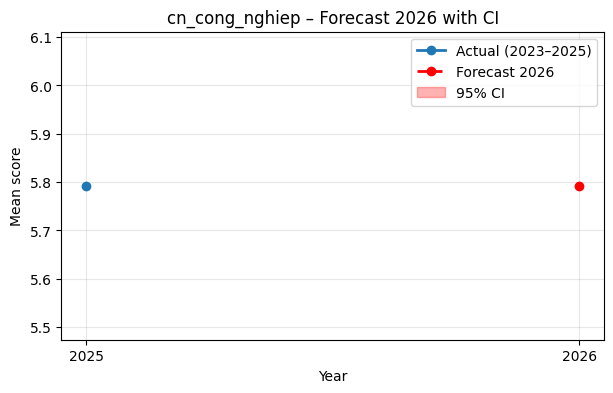

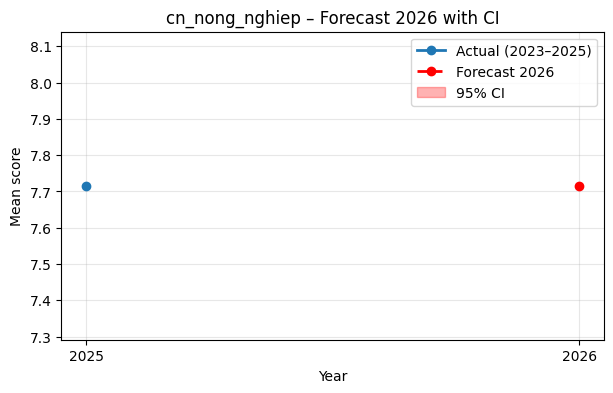

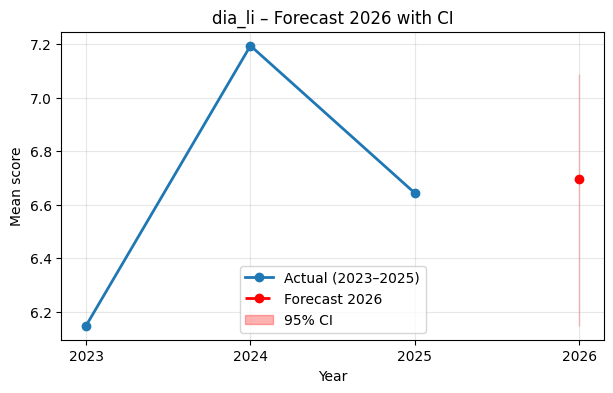

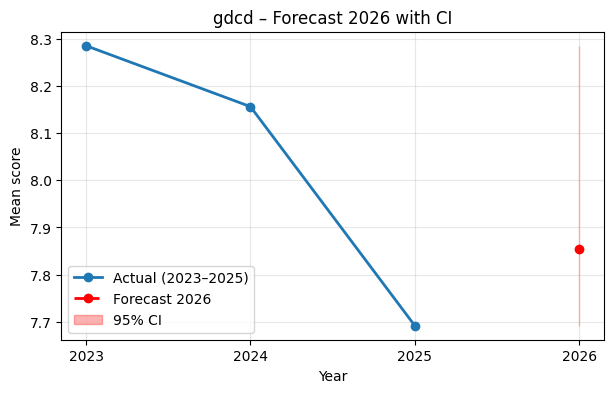

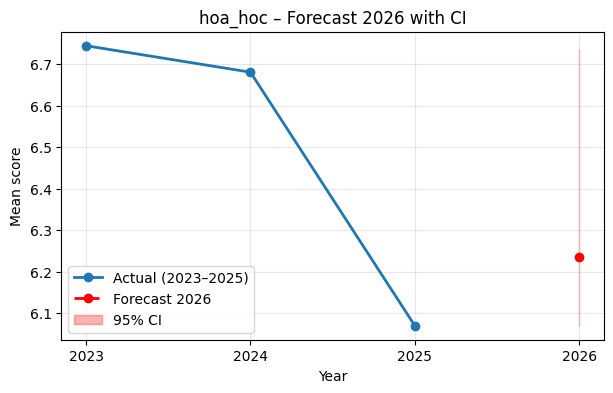

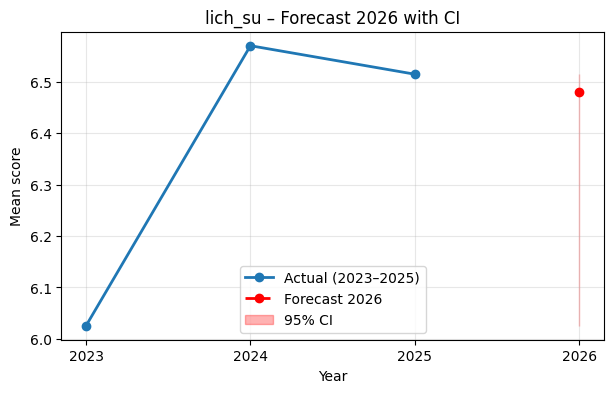

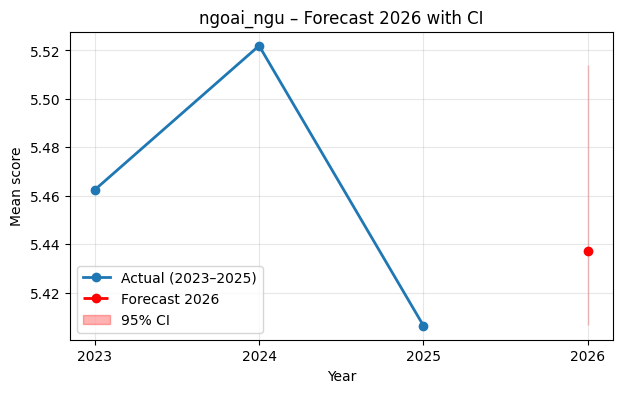

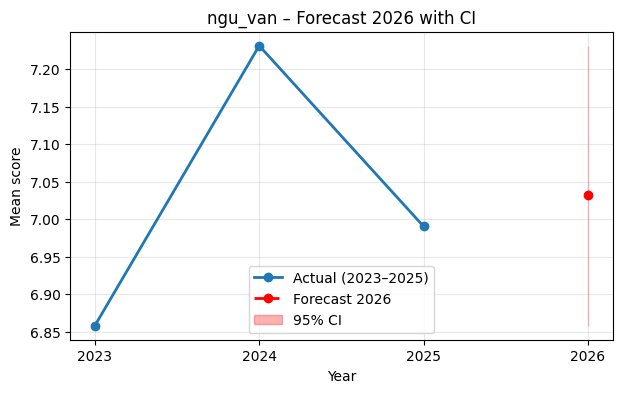

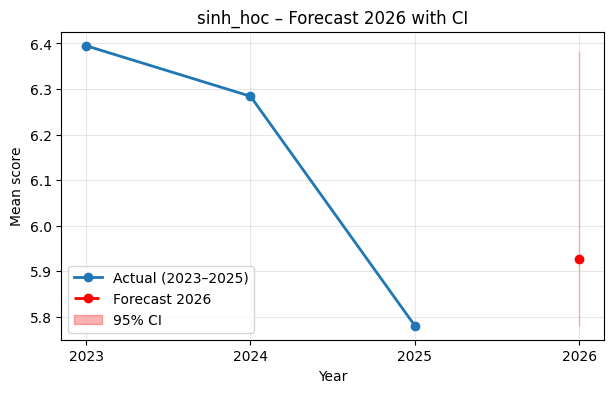

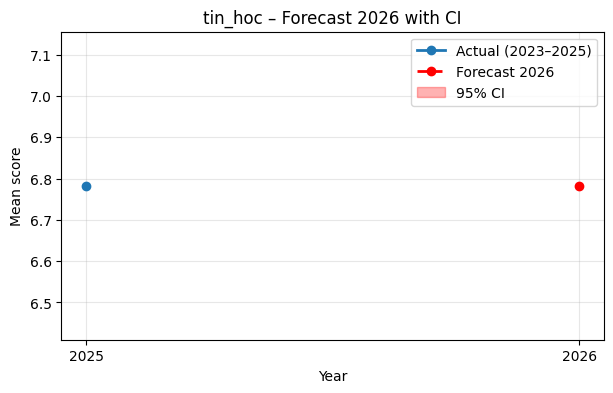

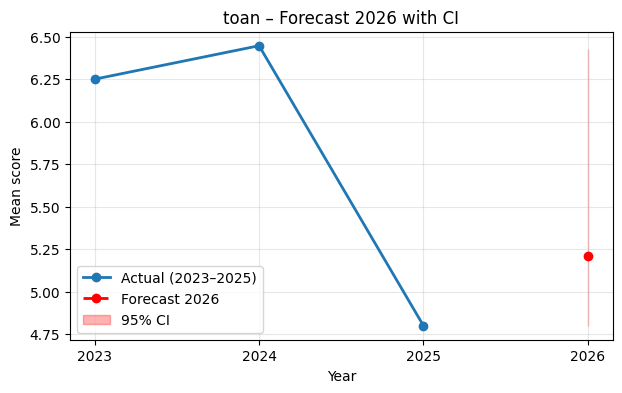

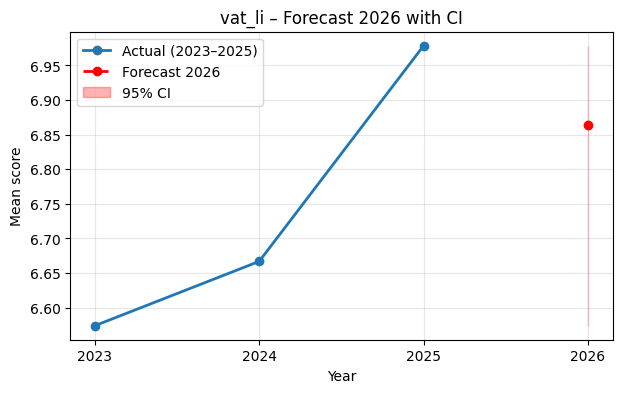

In [22]:
for subj in subjects:
    df_subj = df_all_forecasts[df_all_forecasts["subject"] == subj]

    plt.figure(figsize=(7,4))

    # ----- Actual 2023–2025 -----
    df_actual = df_subj[df_subj["mean_actual"].notna()]
    plt.plot(
        df_actual["year"],
        df_actual["mean_actual"],
        marker='o',
        linewidth=2,
        label="Actual (2023–2025)"
    )

    # ----- Forecast 2026 -----
    df_fc = df_subj[df_subj["year"] == 2026]

    plt.plot(
        df_fc["year"],
        df_fc["mean_predicted"],
        marker='o',
        linestyle='--',
        color='red',
        linewidth=2,
        label="Forecast 2026"
    )

    # ----- CI (CHỈ cho 2026) -----
    if df_fc[["lower_CI", "upper_CI"]].notna().all(axis=None):
        plt.fill_between(
            df_fc["year"],
            df_fc["lower_CI"],
            df_fc["upper_CI"],
            color='red',
            alpha=0.3,
            label="95% CI"
        )

    plt.title(f"{subj} – Forecast 2026 with CI")
    plt.xlabel("Year")
    plt.ylabel("Mean score")
    plt.xticks(df_subj["year"].unique())
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


---

### Dự báo tỉ lệ tổ hợp khối thi năm 2026

#### Mục tiêu

- Dự báo **tỉ lệ thí sinh đăng ký các khối chính** (A00, A01, B00, C00, D01, D07, D08, D09, A02, A03) trong năm 2026.
- Tôn trọng thực tế **năm 2025 là “điểm gãy”** do thay đổi chương trình thi, coi 2025 là năm đầu của **regime mới** và 2026 là năm tiếp theo trong cùng regime.
- So sánh, đánh giá mức dịch chuyển tỉ lệ khối thi giữa 3 năm 2023–2025 và kịch bản dự báo cho 2026.


In [23]:
import pandas as pd
from pathlib import Path
from Module.Load_Data import CleanDataLoader
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge  
from sklearn.metrics import mean_absolute_error, r2_score


def load_all_block_analysis_with_features(
    clean_data: CleanDataLoader,
) -> pd.DataFrame:
    """
    - Đọc toàn bộ Export_Analysis_<BLOCK>.csv và Export_Distribution_<BLOCK>.csv
      từ Block_Data để tạo bảng feature cho train.
    - Thêm:
        + n_students: số thí sinh của khối đó trong từng năm (từ distribution)
        + total_students_year: tổng số thí sinh toàn năm (từ clean_data.get_total_students())
      (KHÔNG tính share_in_year ở đây, sẽ tính sau khi gộp khoi_group)
    """

    block_root: Path = clean_data.block_data_root
    if not block_root.exists():
        raise FileNotFoundError(f"Block_Data folder không tồn tại: {block_root}")

    all_dfs = []

    # Tiền tố folder: CleanData_<BLOCK> (ví dụ CleanData_A00)
    folder_prefix = clean_data._block_data_f_prefix + "_"   # "CleanData_"

    for sub in block_root.iterdir():
        if not sub.is_dir():
            continue

        folder_name = sub.name
        if not folder_name.startswith(folder_prefix):
            continue

        # Lấy mã khối: CleanData_A00 -> A00
        block_code = folder_name[len(folder_prefix):]

        # 1) Đọc file analysis
        try:
            df_anal = clean_data.get_block_data(block=block_code, kind="analysis").copy()
        except FileNotFoundError:
            continue

        if "khoi" not in df_anal.columns:
            df_anal["khoi"] = block_code

        # 2) Đọc file distribution để đếm n_students theo năm
        try:
            df_dist = clean_data.get_block_data(block=block_code, kind="distribution").copy()
        except FileNotFoundError:
            df_dist = pd.DataFrame(columns=["nam_hoc", "so_hoc_sinh"])

        if not df_dist.empty:
            # Xác định cột đếm số học sinh
            if "so_hoc_sinh" in df_dist.columns:
                cnt_col = "so_hoc_sinh"
                counts = (
                    df_dist.groupby("nam_hoc")[cnt_col]
                           .sum()
                           .reset_index(name="n_students")
                )
            elif "count" in df_dist.columns:
                cnt_col = "count"
                counts = (
                    df_dist.groupby("nam_hoc")[cnt_col]
                           .sum()
                           .reset_index(name="n_students")
                )
            else:
                # fallback: chỉ đếm số dòng theo năm
                counts = (
                    df_dist.groupby("nam_hoc")
                           .size()
                           .reset_index(name="n_students")
                )
        else:
            counts = pd.DataFrame(columns=["nam_hoc", "n_students"])

        # 3) Merge n_students vào analysis
        df_merged = df_anal.merge(counts, on="nam_hoc", how="left")
        all_dfs.append(df_merged)

    if not all_dfs:
        return pd.DataFrame()

    block_analysis_all = pd.concat(all_dfs, ignore_index=True)

    # --- 4. Lấy tổng số thí sinh theo năm từ CleanDataLoader ---
    df_total = clean_data.get_total_students().copy()

    # Chuẩn hoá tên cột tổng số thí sinh về 'total_students_year'
    if "total_students_year" not in df_total.columns:
        for cand in ["tong_thi_sinh", "total_students", "so_thi_sinh",
                     "tong_hoc_sinh", "n_students"]:
            if cand in df_total.columns:
                df_total = df_total.rename(columns={cand: "total_students_year"})
                break

    if "nam_hoc" not in df_total.columns:
        raise ValueError(
            "DataFrame từ get_total_students() phải có cột 'nam_hoc'."
        )

    # Merge tổng thí sinh năm vào bảng feature
    block_analysis_all = block_analysis_all.merge(
        df_total[["nam_hoc", "total_students_year"]],
        on="nam_hoc",
        how="left"
    )

    # KHÔNG tính share_in_year ở đây nữa
    return block_analysis_all


In [24]:
clean_data = CleanDataLoader(project_root=project_root_dir)

df_block_features = load_all_block_analysis_with_features(clean_data=clean_data)
df_block_features

,nam_hoc,mean,median,mode,std,min,max,khoi,n_students,total_students_year
0,2023,20.774499,21.150,22.10,3.094093,0.45,29.35,A00,325902,1017584
1,2024,20.904633,21.300,22.80,3.380354,2.15,29.60,A00,343800,1061604
2,2025,19.384368,19.250,22.00,4.337350,1.70,30.00,A00,165467,1153072
3,2023,20.275288,20.450,20.50,3.339521,5.05,29.80,A01,315146,1017584
4,2024,20.473793,20.750,21.00,3.350473,5.20,29.60,A01,329761,1061604
...,...,...,...,...,...,...,...,...,...,...
152,2025,20.486105,20.750,21.50,2.593046,8.95,26.50,Y07,475,1153072
153,2025,19.659654,19.900,21.00,2.518257,13.25,25.25,Y08,260,1153072
154,2025,21.366093,21.750,22.75,2.741671,7.25,28.50,Y09,9493,1153072
155,2025,17.617708,16.925,16.60,2.435760,13.95,24.00,Y10,48,1153072


#### Chuẩn bị dữ liệu cho mô hình

- Dữ liệu đầu vào: bảng tổng hợp theo **năm–khối** `df_block_features` với các cột:
  - `nam_hoc`, `khoi`, `mean`, `median`, `mode`, `std`, `min`, `max`,
  - `n_students`, `total_students_year`.
- Chọn **10 khối chính** để phân tích: `TOP_BLOCKS = ["A00", "A01", "B00", "C00", "D01", "D07", "D08", "D09", "A02", "A03"]`.
- Tạo bảng làm việc `df_top`:
  - Lọc theo `TOP_BLOCKS`.
  - Chuẩn hoá kiểu dữ liệu (`nam_hoc` dạng số nguyên).
- Tính **tỉ lệ trong năm** cho từng khối:
  - `share_in_year = n_students / total_students_year`.
  - Chuẩn hoá lại trong 10 khối: tổng `share_in_year` theo từng năm ≈ 1.
- Tạo thêm các đặc trưng:
  - `year_idx = nam_hoc - nam_hoc.min()` (chỉ số thời gian).
  - `share_lag1`: độ trễ 1 năm theo từng khối (share năm trước).
  - `delta_share = share_in_year - share_lag1` (mức thay đổi so với năm trước).
  - `post_2025 = 1` nếu `nam_hoc ≥ 2025`, ngược lại `0`  
    → mã hoá việc **2025 là điểm gãy** (chương trình mới).


In [ ]:
# ============================================
# [BLOCK-PREP] Chuẩn hoá dữ liệu tổ hợp cho 2023–2025
# ============================================

# 1) Chọn 10 khối chính
TOP_BLOCKS = ["A00", "A01", "B00", "C00", "D01",
              "D07", "D08", "D09", "A02", "A03"]

# df_block_features: bảng tổng hợp theo năm-khối có sẵn từ phần trước
df_top = df_block_features[df_block_features["khoi"].isin(TOP_BLOCKS)].copy()

# Ép kiểu cơ bản
df_top["nam_hoc"] = pd.to_numeric(df_top["nam_hoc"], errors="coerce")
df_top = df_top.dropna(subset=["nam_hoc"]).copy()
df_top["nam_hoc"] = df_top["nam_hoc"].astype(int)

for col in ["mean", "median", "mode", "std", "min", "max", "n_students", "total_students_year"]:
    if col in df_top.columns:
        df_top[col] = pd.to_numeric(df_top[col], errors="coerce")

# 2) Tính share_in_year TRONG 10 KHỐI (chuẩn hoá theo tổng 10 khối)
df_top["share_in_year"] = df_top["n_students"] / df_top["total_students_year"]
df_top["share_in_year"] = df_top["share_in_year"] / (
    df_top.groupby("nam_hoc")["share_in_year"].transform("sum") + 1e-12
)

# 3) Tạo year_idx (2023 -> 0, 2024 -> 1, 2025 -> 2)
df_top["year_idx"] = df_top["nam_hoc"] - df_top["nam_hoc"].min()

# 4) Tạo feature lag theo từng khối
df_top = df_top.sort_values(["khoi", "nam_hoc"]).reset_index(drop=True)

df_top["share_lag1"] = (
    df_top.groupby("khoi")["share_in_year"]
          .shift(1)
)
df_top["delta_share"] = df_top["share_in_year"] - df_top["share_lag1"]

# 5) Thêm feature post_2025 để encode “sau điểm gãy 2025”
df_top["post_2025"] = (df_top["nam_hoc"] >= 2025).astype(int)

print("Years:", sorted(df_top["nam_hoc"].unique()))
print("Blocks:", sorted(df_top["khoi"].unique()))
print("Sum share per year (should ≈1):")
print(df_top.groupby("nam_hoc")["share_in_year"].sum().sort_index())

display(df_top.head())


Years: [np.int64(2023), np.int64(2024), np.int64(2025)]
Blocks: ['A00', 'A01', 'A02', 'A03', 'B00', 'C00', 'D01', 'D07', 'D08', 'D09']
Sum share per year (should ≈1):
nam_hoc
2023    1.0
2024    1.0
2025    1.0
Name: share_in_year, dtype: float64


,nam_hoc,mean,median,mode,std,min,max,khoi,n_students,total_students_year,share_in_year,year_idx,share_lag1,delta_share,post_2025
0,2023,20.774499,21.15,22.1,3.094093,0.45,29.35,A00,325902,1017584,0.070797,0,NaN,NaN,0
1,2024,20.904633,21.30,22.8,3.380354,2.15,29.60,A00,343800,1061604,0.071852,1,0.070797,0.001055,0
2,2025,19.384368,19.25,22.0,4.337350,1.70,30.00,A00,165467,1153072,0.110738,2,0.071852,0.038886,1
3,2023,20.275288,20.45,20.5,3.339521,5.05,29.80,A01,315146,1017584,0.068460,0,NaN,NaN,0
4,2024,20.473793,20.75,21.0,3.350473,5.20,29.60,A01,329761,1061604,0.068918,1,0.068460,0.000458,0


#### Các mô hình dự báo tỉ lệ tổ hợp

Ba mô hình hồi quy / chuỗi thời gian được triển khai trong Notebook:

1. **Linear-GD (baseline)**  
   - Mô hình hồi quy tuyến tính đơn giản theo `year_idx` cho từng khối riêng lẻ.  
   - Được huấn luyện bằng Gradient Descent (class `LinearRegressionGD`).  
   - Mục đích chính: làm baseline so sánh, **không dùng trực tiếp để dự báo 2026**.

2. **Multi-REG (MultiShareRegressor)**  
   - Mô hình hồi quy Ridge trong không gian đặc trưng:
     - `year_idx`, `share_lag1`, `delta_share`,
     - các thống kê điểm: `mean`, `median`, `std`,
     - quy mô: `n_students`, `total_students_year`,
     - chỉ báo chế độ: `post_2025`.
   - Dùng one-hot cho `khoi_group` để học chung cho toàn bộ khối.
   - Đầu ra được chuẩn hoá bằng **softmax** để đảm bảo là phân phối xác suất trên các khối.

3. **ARIMA theo từng khối (ArimaShareModel)**  
   - Xây dựng chuỗi thời gian `share_in_year` cho từng khối.  
   - Dùng mô hình ARIMA đơn giản (AR(1) nếu đủ điểm, AR(0) nếu chuỗi quá ngắn).  
   - Dự báo riêng cho từng khối, sau đó chuẩn hoá lại để tổng tỉ lệ bằng 1.

- Linear Regression

In [27]:
import numpy as np
# Linear Regression với Gradient Descent
class LinearRegressionGD:
    def __init__(
        self,
        lr: float = 0.01,
        n_iter: int = 2000,
        reg_lambda: float = 0.0,
        verbose: bool = False,
        random_state: int | None = None,
    ):
        """
        Linear Regression (OLS) huấn luyện bằng Gradient Descent.

        lr         : learning rate
        n_iter     : số vòng lặp GD
        reg_lambda : hệ số L2 regularization (0 = không regularize)
        """
        self.lr = lr
        self.n_iter = n_iter
        self.reg_lambda = reg_lambda
        self.verbose = verbose
        self.random_state = random_state

        self.W = None   # (d,)
        self.b = None   # scalar

    # Huấn luyện model với dữ liệu X, y
    def fit(self, X: np.ndarray, y: np.ndarray):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float).reshape(-1)

        # Kích thước dữ liệu
        N, d = X.shape

        # Khởi tạo tham số
        rng = np.random.default_rng(self.random_state)
        self.W = rng.normal(loc=0.0, scale=0.01, size=d)
        self.b = 0.0

        # Thực hiện tìm Gradient Descent
        for it in range(self.n_iter):
            # y_hat = XW + b: Dự đoán
            y_hat = X @ self.W + self.b  # (N,)

            # residuals: đo sai số giữa dự đoán và thực tế ( Tính mất mát )
            err = y_hat - y             # (N,)

            # gradient (MSE + L2): 
            dW = (X.T @ err) / N + self.reg_lambda * self.W   # (d,)
            db = err.mean()                                   # scalar

            # update: Cập nhật tham số
            self.W -= self.lr * dW
            self.b -= self.lr * db

            # Kiểm tra loss mỗi 200 vòng hoặc vòng cuối
            if self.verbose and (it % 200 == 0 or it == self.n_iter - 1):
                mse = (err ** 2).mean()
                loss = mse + 0.5 * self.reg_lambda * np.sum(self.W ** 2)
                # print(f"Iter {it:4d} | loss = {loss:.8f}")

        return self

    # Dự đoán với dữ liệu X mới
    def predict(self, X: np.ndarray) -> np.ndarray:
        if self.W is None:
            raise ValueError("Model chưa được fit.")
        X = np.asarray(X, dtype=float)
        return X @ self.W + self.b


- Multi Share

In [28]:
class MultiShareRegressor:
    """
    Regression model dự đoán share_in_year.
    - X = base_features + one-hot khoi_group
    - y = share_in_year
    - Predict theo năm: clip >=0 + normalize tổng = 1
    Workflow:
      fit(df_model) -> evaluate(df_model, year) -> forecast(df, next_year)
    """
    def __init__(self, base_features, alpha=1.0, random_state=42, normalize_method="softmax", temperature=2.0):
        self.base_features = list(base_features)
        self.alpha = float(alpha)
        self.random_state = random_state
        self.normalize_method = normalize_method  # "softmax" or "shift"
        self.temperature = float(temperature)

        self.model = Pipeline([
            ("scaler", StandardScaler()),
            ("ridge", Ridge(alpha=self.alpha, random_state=self.random_state))
        ])

        self.dummy_cols_ = None
        self._fitted = False

    @staticmethod
    def _softmax(v, temp=1.0):
        v = np.asarray(v, dtype=float)
        z = (v - np.max(v)) / max(temp, 1e-9)
        e = np.exp(z)
        return e / (e.sum() + 1e-12)

    @staticmethod
    def _shift_norm(v):
        v = np.asarray(v, dtype=float)
        v = v - np.min(v) + 1e-9
        return v / (v.sum() + 1e-12)

    def _clean(self, df):
        out = df.copy()
        out["nam_hoc"] = pd.to_numeric(out["nam_hoc"], errors="coerce")
        out = out.dropna(subset=["nam_hoc", "khoi_group", "share_in_year"])
        out["nam_hoc"] = out["nam_hoc"].astype(int)
        out["khoi_group"] = out["khoi_group"].astype(str)

        for c in self.base_features + ["share_in_year"]:
            if c in out.columns:
                out[c] = pd.to_numeric(out[c], errors="coerce")
        out = out.replace([np.inf, -np.inf], np.nan).dropna(subset=self.base_features + ["share_in_year"])
        return out

    def _build_X(self, df):
        dummies = pd.get_dummies(df["khoi_group"], prefix="khoi_group")

        # lúc fit: lưu danh sách cột dummy chuẩn
        if self.dummy_cols_ is None:
            self.dummy_cols_ = list(dummies.columns)

        # lúc predict: align cột dummy
        for col in self.dummy_cols_:
            if col not in dummies.columns:
                dummies[col] = 0
        dummies = dummies[self.dummy_cols_]

        X = pd.concat([df[self.base_features].reset_index(drop=True), dummies.reset_index(drop=True)], axis=1)
        return X

    def fit(self, df_train, weight_col="n_students"):
        df_train = self._clean(df_train)

        X = self._build_X(df_train).values
        y = df_train["share_in_year"].values.astype(float)

        # sample_weight theo quy mô (optional)
        if weight_col in df_train.columns:
            w = pd.to_numeric(df_train[weight_col], errors="coerce").fillna(1.0).values.astype(float)
        else:
            w = None

        if w is None:
            self.model.fit(X, y)
        else:
            self.model.fit(X, y, ridge__sample_weight=w)

        self._fitted = True
        return self

    def predict_raw(self, df_any):
        if not self._fitted:
            raise RuntimeError("Model chưa fit().")
        df_any = self._clean(df_any)
        X = self._build_X(df_any).values
        y_raw = self.model.predict(X).astype(float)
        return df_any, y_raw

    def predict_share_year(self, df_year):
        df_year, y_raw = self.predict_raw(df_year)

        if self.normalize_method == "softmax":
            share = self._softmax(y_raw, temp=self.temperature)
        else:
            share = self._shift_norm(y_raw)

        out = pd.DataFrame({
            "khoi_group": df_year["khoi_group"].values,
            "share_pred": share
        })

        # đảm bảo tổng = 1
        out["share_pred"] = out["share_pred"] / (out["share_pred"].sum() + 1e-12)
        return out

    def evaluate_year(self, df_all, year):
        df_all = self._clean(df_all)
        year = int(year)

        df_year = df_all[df_all["nam_hoc"] == year].copy()

        df_true = df_year[["khoi_group","share_in_year"]].copy()
        df_true = df_true.groupby("khoi_group", as_index=False)["share_in_year"].sum()
        df_true = df_true.rename(columns={"share_in_year":"share_true"})
        df_true["share_true"] = df_true["share_true"] / (df_true["share_true"].sum() + 1e-12)

        df_pred = self.predict_share_year(df_year[["nam_hoc","khoi_group","share_in_year"] + self.base_features])

        df_eval = df_true.merge(df_pred, on="khoi_group", how="outer").fillna(0)
        df_eval["abs_err"] = (df_eval["share_true"] - df_eval["share_pred"]).abs()

        mae = float(df_eval["abs_err"].mean())
        return df_eval.sort_values("abs_err", ascending=False).reset_index(drop=True), mae

    def build_features_for_next_year(self, df_all):
        """
        Tạo df_next (năm max+1) theo logic:
          - year_idx tăng 1
          - share_lag1 = share_in_year năm cuối
          - delta_share = share_in_year(last) - share_in_year(last-1)
          - các stats khác copy từ năm cuối (mean/median/std/n_students/total_students_year)
        """
        df_all = self._clean(df_all)
        last_year = int(df_all["nam_hoc"].max())
        prev_year = last_year - 1

        df_last = df_all[df_all["nam_hoc"] == last_year].copy()
        df_prev = df_all[df_all["nam_hoc"] == prev_year][["khoi_group","share_in_year"]].copy()
        df_prev = df_prev.rename(columns={"share_in_year":"share_prev"})

        df_next = df_last.merge(df_prev, on="khoi_group", how="left")
        df_next["share_lag1"] = df_next["share_in_year"]
        df_next["delta_share"] = df_next["share_in_year"] - df_next["share_prev"].fillna(df_next["share_in_year"])
        df_next["year_idx"] = int(df_last["year_idx"].max()) + 1
        df_next["nam_hoc"] = last_year + 1

        # đảm bảo đủ base_features
        for c in self.base_features:
            if c not in df_next.columns:
                df_next[c] = 0

        return df_next[["nam_hoc","khoi_group","share_in_year"] + self.base_features].copy()

    def forecast_next_year(self, df_all):
        df_next = self.build_features_for_next_year(df_all)
        return self.predict_share_year(df_next)


- ARIMA Forecast

In [29]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA forecast cho share theo từng khoi_group
class ArimaShareModel:
    """
    ARIMA forecast cho share theo từng khoi_group.
    - Fix warning bằng PeriodIndex(freq="Y")
    - Forecast từng group, clip >= 1e-9
    - Normalize tổng share = 1
    """
    def __init__(self, min_points_for_ar1=4):
        self.min_points_for_ar1 = min_points_for_ar1

    @staticmethod
    def _to_series(sub_df):
        years = sub_df["nam_hoc"].astype(int).tolist()
        vals = pd.to_numeric(sub_df["share_in_year"], errors="coerce").astype(float).tolist()
        s = pd.Series(vals, index=pd.PeriodIndex(years, freq="Y")).asfreq("Y")
        return s

    def _forecast_one(self, s: pd.Series):
        s = s.astype(float)
        if len(s) < 2:
            return float(s.iloc[-1])
        order = (1,0,0) if len(s) >= self.min_points_for_ar1 else (0,0,0)
        try:
            res = ARIMA(s, order=order).fit()
            return float(res.forecast(steps=1).iloc[0])
        except Exception:
            return float(s.iloc[-1])

    def forecast_year(self, df_all, target_year):
        df_all = df_all.copy()
        df_all["nam_hoc"] = df_all["nam_hoc"].astype(int)
        df_all["khoi_group"] = df_all["khoi_group"].astype(str)
        df_all["share_in_year"] = pd.to_numeric(df_all["share_in_year"], errors="coerce")
        df_all = df_all.dropna(subset=["share_in_year"])

        preds = {}
        for g, sub in df_all.groupby("khoi_group"):
            sub = sub.sort_values("nam_hoc")
            sub = sub[sub["nam_hoc"] < int(target_year)]
            if len(sub) == 0:
                continue
            s = self._to_series(sub)
            yhat = self._forecast_one(s)
            preds[g] = max(yhat, 1e-9)

        pred = pd.Series(preds, name=f"share_pred_{int(target_year)}")
        pred = pred / pred.sum()
        return pred.reset_index().rename(columns={"index": "khoi_group"})

    def evaluate_year(self, df_all, year):
        year = int(year)
        df_all = df_all.copy()
        df_all["nam_hoc"] = df_all["nam_hoc"].astype(int)

        df_true = df_all[df_all["nam_hoc"] == year][["khoi_group", "share_in_year"]].copy()
        df_true = df_true.groupby("khoi_group", as_index=False)["share_in_year"].mean()
        df_true = df_true.rename(columns={"share_in_year": "share_true"})

        df_pred = self.forecast_year(df_all, target_year=year)
        pred_col = f"share_pred_{year}"

        df_eval = df_true.merge(df_pred, on="khoi_group", how="outer").fillna(0)
        df_eval["abs_err"] = (df_eval["share_true"] - df_eval[pred_col]).abs()
        mae = df_eval["abs_err"].mean()
        return df_eval.sort_values("abs_err", ascending=False).reset_index(drop=True), mae


#### Chiến lược đánh giá và chọn mô hình (năm 2025)

- Năm 2025 được sử dụng làm **năm kiểm tra**:
  - Với mỗi mô hình, huấn luyện trên các năm trước 2025 và dự báo `share_in_year` 2025.
  - So sánh với `share_in_year` thực tế năm 2025.
- Chỉ số đánh giá chính: **MAE trên tỉ lệ khối**:
  \[
    \text{MAE}_{2025}
    = \frac{1}{K} \sum_{k \in \text{TOP\_BLOCKS}}
      \left| \hat{share}_{2025}(k) - share_{2025}(k) \right|.
  \]
- Tạo bảng `df_mae_compare_2025` gồm 3 dòng:
  - Linear-GD (baseline)
  - Multi-REG
  - ARIMA
- **Top–2 mô hình có MAE nhỏ nhất** trong tập {Multi-REG, ARIMA}  
  được chọn làm **mô hình chính** để dự báo tỉ lệ tổ hợp năm 2026.


In [54]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

# ============================================
# [BLOCK-MODELS] Fit Linear-GD, Multi-REG, ARIMA & so sánh MAE 2025
# ============================================

YEAR_TEST = 2025  # năm dùng để đánh giá forecast share

# 1) Chuẩn hoá df_block_all cho MultiShareRegressor / ARIMA
df_block_all = df_top.copy().rename(columns={"khoi": "khoi_group"})

base_features_block = [
    "year_idx",
    "share_lag1",
    "delta_share",
    "mean", "median", "std",
    "n_students", "total_students_year",
    "post_2025"
]

missing_cols = [c for c in base_features_block if c not in df_block_all.columns]
if missing_cols:
    print("⚠️ Thiếu base_features chưa tính:", missing_cols)

df_block_all = df_block_all[["nam_hoc", "khoi_group", "share_in_year"] + base_features_block].copy()

# 2) Multi-REG (MultiShareRegressor)
multi_reg_top = MultiShareRegressor(
    base_features=base_features_block,
    alpha=1.0,
    random_state=42,
    normalize_method="softmax",
    temperature=2.0,
)
multi_reg_top.fit(df_block_all, weight_col="n_students")
eval_multi_2025, mae_multi_top_2025 = multi_reg_top.evaluate_year(df_block_all, YEAR_TEST)
print(f"MAE_2025 (Multi-REG) = {mae_multi_top_2025:.6f}")

# 3) ARIMA (ArimaShareModel)
arima_top = ArimaShareModel(min_points_for_ar1=3)
eval_arima_2025, mae_arima_top_2025 = arima_top.evaluate_year(df_block_all, YEAR_TEST)
print(f"MAE_2025 (ARIMA) = {mae_arima_top_2025:.6f}")

# 4) Baseline Linear-GD: dùng LinearRegressionGD theo year_idx cho từng khối
def eval_linear_gd_share(df_top, year_test, lr=0.01, n_iter=2000):
    abs_err_list = []
    for khoi, sub in df_top.groupby("khoi"):
        sub = sub.sort_values("nam_hoc")
        if sub["nam_hoc"].nunique() < 2:
            continue

        train = sub[sub["nam_hoc"] != year_test]
        test = sub[sub["nam_hoc"] == year_test]
        if train.empty or test.empty:
            continue

        X_train = train[["year_idx"]].values
        y_train = train["share_in_year"].values

        model = LinearRegressionGD(
            lr=lr, n_iter=n_iter,
            reg_lambda=0.0,
            random_state=42
        )
        model.fit(X_train, y_train)

        y_hat = model.predict(test[["year_idx"]].values)[0]
        abs_err = float(abs(y_hat - test["share_in_year"].iloc[0]))
        abs_err_list.append(abs_err)

    if len(abs_err_list) == 0:
        return np.nan
    return float(np.mean(abs_err_list))

mae_lin_top = eval_linear_gd_share(df_top, YEAR_TEST)
print(f"MAE_2025 (Linear-GD baseline) = {mae_lin_top:.6f}")

# 5) Tổng hợp bảng so sánh MAE
rows = [
    {
        "model_display": "Linear-GD (baseline)",
        "model_id": "LinearGD",
        "MAE_2025": mae_lin_top,
    },
    {
        "model_display": "Multi-REG (Ridge + features)",
        "model_id": "MultiShareReg",
        "MAE_2025": mae_multi_top_2025,
    },
    {
        "model_display": "ARIMA (per-block TS)",
        "model_id": "ARIMA",
        "MAE_2025": mae_arima_top_2025,
    },
]

df_mae_compare_2025 = pd.DataFrame(rows)
df_mae_compare_2025 = df_mae_compare_2025.sort_values("MAE_2025").reset_index(drop=True)

print("\n🔎 So sánh MAE năm 2025 giữa các model:")
display(df_mae_compare_2025[["model_display", "MAE_2025"]])

# Top-2 để forecast: chỉ chọn trong Multi-REG & ARIMA (LinearGD chỉ baseline)
forecast_candidates = ["MultiShareReg", "ARIMA"]
top2_forecast_ids = [
    mid for mid in df_mae_compare_2025["model_id"]
    if mid in forecast_candidates
][:2]

print("👉 Top-2 model dùng cho forecast 2026:", top2_forecast_ids)


MAE_2025 (Multi-REG) = 0.076964


c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE_2025 (ARIMA) = 0.048791
MAE_2025 (Linear-GD baseline) = 0.052735

🔎 So sánh MAE năm 2025 giữa các model:


,model_display,MAE_2025
0,ARIMA (per-block TS),0.048791
1,Linear-GD (baseline),0.052735
2,Multi-REG (Ridge + features),0.076964


👉 Top-2 model dùng cho forecast 2026: ['ARIMA', 'MultiShareReg']


#### Quy trình dự báo tỉ lệ tổ hợp năm 2026

Quy trình trong Notebook gồm các bước:

1. **Huấn luyện Multi-REG và ARIMA trên dữ liệu 2023–2025**  
   (hoặc 2018–2025 nếu có thêm dữ liệu lịch sử).
2. **Dự báo thô 2026 cho từng khối**:
   - Multi-REG: `forecast_next_year(df_block_all)` → `share_2026_multi`.
   - ARIMA: `forecast_year(df_block_all, 2026)` → `share_2026_arima`.
3. **Tôn trọng “điểm gãy 2025” bằng hậu xử lý**:
   - Lấy phân bố thực tế năm 2025: `share_2025(k)` cho từng khối.
   - Tạo dự báo ensemble:
     \[
       share\_{2026}^{blend}(k)
       = w_{\text{multi}} \cdot share\_{2026}^{multi}(k)
       + w_{\text{arima}} \cdot share\_{2026}^{arima}(k)
     \]
     với \(w_{\text{multi}} = 0.6,\ w_{\text{arima}} = 0.4\).
   - Neo kết quả về phân bố 2025 (do 2026 là năm ngay sau điểm gãy):
     \[
       share\_{2026}^{mix}(k)
       = (1 - \gamma) \cdot share\_{2026}^{blend}(k)
       + \gamma \cdot share_{2025}(k),
     \]
     với \(\gamma \approx 0.2\).
   - Giới hạn mức thay đổi cho từng khối (tránh dự báo cực đoan):
     \[
       |share\_{2026}^{final}(k) - share_{2025}(k)| \leq \text{max\_change},
     \]
     với `max_change` (ví dụ 0.10).  
     Sau khi clip, chuẩn hoá lại để tổng tỉ lệ bằng 1.
4. **Kết quả cuối cùng**:
   - Thu được bảng `df_pred_2026_final` gồm:
     - `khoi`, `share_2025`, `share_2026_multi`, `share_2026_arima`, `share_2026_final`.
   - `share_2026_final` được sử dụng làm **kịch bản dự báo chính** cho năm 2026.

In [57]:
# ============================================
# [BLOCK-FORECAST-2026] Ensemble Multi-REG + ARIMA cho tỉ lệ tổ hợp 2026
# ============================================

YEAR_FORECAST = YEAR_TEST + 1  # = 2026

# --- Dự báo 2026 từ Multi-REG ---
df_pred_2026_multi = None
if "MultiShareReg" in top2_forecast_ids:
    df_pred_2026_multi = multi_reg_top.forecast_next_year(df_block_all)
    df_pred_2026_multi = df_pred_2026_multi.rename(
        columns={"khoi_group": "khoi", "share_pred": "share_2026_multi"}
    )
    df_pred_2026_multi["nam_hoc"] = YEAR_FORECAST
    df_pred_2026_multi["share_2026_multi"] /= df_pred_2026_multi["share_2026_multi"].sum()

# --- Dự báo 2026 từ ARIMA ---
df_pred_2026_arima = None
if "ARIMA" in top2_forecast_ids:
    tmp = arima_top.forecast_year(df_block_all, target_year=YEAR_FORECAST)
    pred_col = f"share_pred_{YEAR_FORECAST}"
    df_pred_2026_arima = tmp.rename(
        columns={"khoi_group": "khoi", pred_col: "share_2026_arima"}
    )
    df_pred_2026_arima["nam_hoc"] = YEAR_FORECAST
    df_pred_2026_arima["share_2026_arima"] /= df_pred_2026_arima["share_2026_arima"].sum()

print("\n📊 Dự báo 2026 (raw) Multi-REG:")
if df_pred_2026_multi is not None:
    display(df_pred_2026_multi.sort_values("khoi").reset_index(drop=True))

print("\n📊 Dự báo 2026 (raw) ARIMA:")
if df_pred_2026_arima is not None:
    display(df_pred_2026_arima.sort_values("khoi").reset_index(drop=True))

# --- Neo về 2025 + ensemble + clip ---

# Phân bố thật 2025 trong 10 khối
df_2025 = df_top[df_top["nam_hoc"] == YEAR_TEST].copy()
df_2025 = df_2025[["khoi", "share_in_year"]].rename(columns={"share_in_year": "share_2025"})

df_merge = df_2025.copy()

if df_pred_2026_multi is not None:
    df_merge = df_merge.merge(
        df_pred_2026_multi[["khoi", "share_2026_multi"]],
        on="khoi", how="left"
    )

if df_pred_2026_arima is not None:
    df_merge = df_merge.merge(
        df_pred_2026_arima[["khoi", "share_2026_arima"]],
        on="khoi", how="left"
    )

# Fallback: nếu thiếu dự báo ở model nào → dùng share_2025
for col in ["share_2026_multi", "share_2026_arima"]:
    if col in df_merge.columns:
        df_merge[col] = df_merge[col].fillna(df_merge["share_2025"])

# Ensemble 2 model (tùy top2 có những gì)
if ("share_2026_multi" in df_merge.columns) and ("share_2026_arima" in df_merge.columns):
    w_multi = 0.6  # tin Multi-REG 60%
    w_arima = 0.4  # ARIMA 40%
    df_merge["share_2026_blend"] = (
        w_multi * df_merge["share_2026_multi"] +
        w_arima * df_merge["share_2026_arima"]
    )
elif "share_2026_multi" in df_merge.columns:
    df_merge["share_2026_blend"] = df_merge["share_2026_multi"]
elif "share_2026_arima" in df_merge.columns:
    df_merge["share_2026_blend"] = df_merge["share_2026_arima"]
else:
    raise ValueError("Không có dự báo 2026 từ Multi-REG hoặc ARIMA.")

# Neo về 2025 (tôn trọng 2025 là năm gãy, 2026 ~ dao động quanh baseline 2025)
gamma = 0.2  # 20% kéo về phân bố 2025
df_merge["share_2026_mix"] = (
    (1 - gamma) * df_merge["share_2026_blend"] +
    gamma * df_merge["share_2025"]
)

# Clip: mỗi khối không lệch quá ±10% tuyệt đối so với 2025
max_change = 0.10

base = df_merge["share_2025"].to_numpy()
pred = df_merge["share_2026_mix"].to_numpy()

share_min = np.maximum(base - max_change, 0.0)
share_max = np.minimum(base + max_change, 1.0)

share_final = np.clip(pred, share_min, share_max)
share_final = share_final / share_final.sum()

df_merge["share_2026_final"] = share_final

df_pred_2026_final = df_merge[[
    "khoi",
    "share_2025",
    *(["share_2026_multi"] if "share_2026_multi" in df_merge.columns else []),
    *(["share_2026_arima"] if "share_2026_arima" in df_merge.columns else []),
    "share_2026_final"
]].copy()
df_pred_2026_final["nam_hoc"] = YEAR_FORECAST

print("\n📊 So sánh 2025 vs dự báo 2026 (ensemble + neo + clip):")
display(df_pred_2026_final.sort_values("khoi").reset_index(drop=True))



📊 Dự báo 2026 (raw) Multi-REG:


,khoi,share_2026_multi,nam_hoc
0,A00,0.113029,2026
1,A01,0.111970,2026
2,A02,0.101852,2026
3,B00,0.104586,2026
4,C00,0.119854,2026
5,D01,0.121351,2026
6,D07,0.121488,2026
7,D08,0.101906,2026
8,D09,0.103963,2026



📊 Dự báo 2026 (raw) ARIMA:


,khoi,share_2026_arima,nam_hoc
0,A00,0.072488,2026
1,A01,0.069170,2026
2,A02,0.068659,2026
3,A03,0.011185,2026
4,B00,0.069958,2026
5,C00,0.146926,2026
6,D01,0.189075,2026
7,D07,0.189783,2026
8,D08,0.066045,2026
9,D09,0.116712,2026



📊 So sánh 2025 vs dự báo 2026 (ensemble + neo + clip):


,khoi,share_2025,share_2026_multi,share_2026_arima,share_2026_final,nam_hoc
0,A00,0.110738,0.113029,0.072488,0.099060,2026
1,A01,0.099671,0.111970,0.069170,0.095297,2026
2,A02,0.003820,0.101852,0.068659,0.071237,2026
3,A03,0.011307,0.011307,0.011185,0.011207,2026
4,B00,0.031191,0.104586,0.069958,0.078401,2026
5,C00,0.207474,0.119854,0.146926,0.145253,2026
6,D01,0.241094,0.121351,0.189075,0.166070,2026
7,D07,0.242571,0.121488,0.189783,0.166654,2026
8,D08,0.003149,0.101906,0.066045,0.070298,2026
9,D09,0.048985,0.103963,0.116712,0.096523,2026


#### Kết quả và trực quan hoá

- Vẽ các biểu đồ line theo từng khối tiêu biểu (A00, B00, C00, D01):
  - Trục hoành: năm (2023–2026).
  - Trục tung: `share` trong 10 khối.
  - Đường liền: giá trị thực 2023–2025.
  - Marker tam giác / đường gạch: dự báo năm 2026 (`share_2026_final`).
- Tổng hợp bảng:
  - `nam_hoc, khoi, share` cho các năm 2023–2026
  - dùng để:
    - chèn bảng / biểu đồ vào báo cáo,
    - hoặc xuất ra CSV phục vụ dashboard.

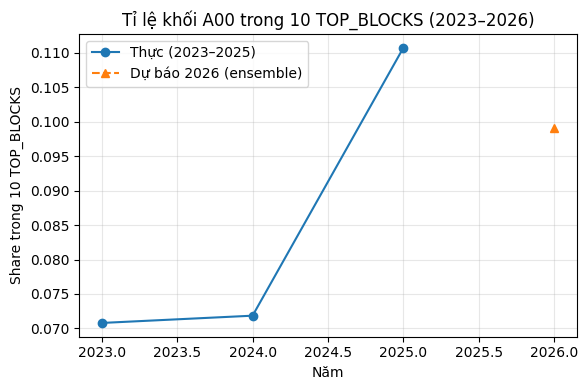

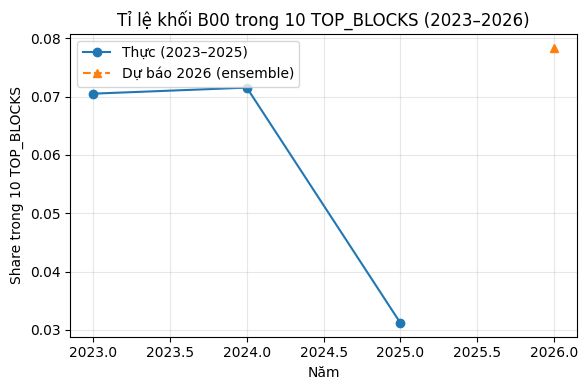

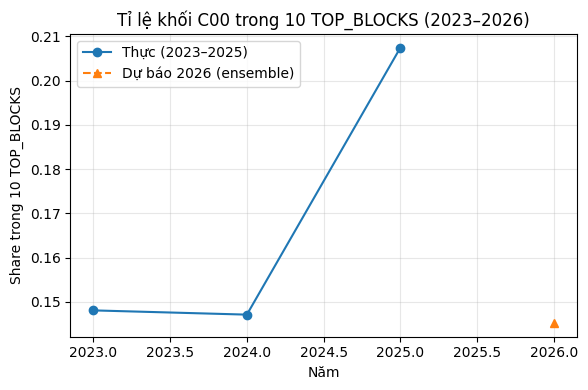

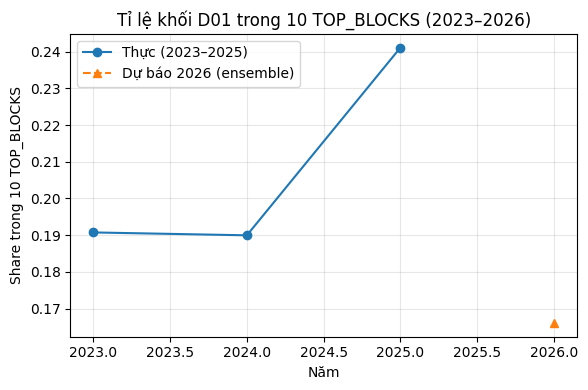


Bảng share 2026 (final):


,nam_hoc,khoi,share
0,2026,A00,0.099060
1,2026,A01,0.095297
2,2026,A02,0.071237
3,2026,A03,0.011207
4,2026,B00,0.078401
5,2026,C00,0.145253
6,2026,D01,0.166070
7,2026,D07,0.166654
8,2026,D08,0.070298
9,2026,D09,0.096523


In [59]:
import matplotlib.pyplot as plt

# ============================================
# [BLOCK-PLOT/EXPORT] Vẽ biểu đồ & gom CSV cho 2023–2026
# ============================================

# 4.1. Vẽ biểu đồ cho một vài khối tiêu biểu
blocks_to_plot = ["A00", "B00", "C00", "D01"]  # có thể đổi thêm

for blk in blocks_to_plot:
    df_hist = df_top[df_top["khoi"] == blk].sort_values("nam_hoc").copy()
    if df_hist.empty:
        continue

    row_2026 = df_pred_2026_final[df_pred_2026_final["khoi"] == blk]
    if row_2026.empty:
        continue

    share_2026 = float(row_2026["share_2026_final"].iloc[0])

    years_hist = df_hist["nam_hoc"].values
    shares_hist = df_hist["share_in_year"].values

    plt.figure(figsize=(6, 4))
    plt.plot(years_hist, shares_hist, marker="o", linestyle="-",
             label="Thực (2023–2025)")

    plt.plot([YEAR_FORECAST], [share_2026],
             marker="^", linestyle="--",
             label=f"Dự báo {YEAR_FORECAST} (ensemble)")

    plt.title(f"Tỉ lệ khối {blk} trong 10 TOP_BLOCKS (2023–{YEAR_FORECAST})")
    plt.xlabel("Năm")
    plt.ylabel("Share trong 10 TOP_BLOCKS")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 4.2. Gom 2023–2026 vào 1 bảng để dùng cho Report / dashboard
df_block_share_2023_2026 = pd.concat([
    df_top[["nam_hoc", "khoi", "share_in_year"]].rename(columns={"share_in_year": "share"}),
    df_pred_2026_final[["nam_hoc", "khoi", "share_2026_final"]].rename(columns={"share_2026_final": "share"})
], ignore_index=True)

df_block_share_2023_2026 = df_block_share_2023_2026.sort_values(["khoi", "nam_hoc"]).reset_index(drop=True)

print("\nBảng share 2026 (final):")
display(df_block_share_2023_2026[df_block_share_2023_2026["nam_hoc"] == YEAR_FORECAST].reset_index(drop=True))

# (tuỳ chọn) lưu file
# df_block_share_2023_2026.to_csv("block_share_2023_2026_ensemble_multi_arima.csv", index=False)
# print("💾 Đã lưu block_share_2023_2026_ensemble_multi_arima.csv")



#### Nhận xét và hạn chế

- Tỉ lệ một số khối truyền thống (A00, B00, C00, D01, D07, …) giảm mạnh năm 2025 do thay đổi chương trình thi (điểm gãy).
- Dự báo 2026 **không kéo thẳng trend 2023–2024**, mà giả định:
  - 2025 là năm đầu của regime mới,
  - 2026 dao động xung quanh phân bố 2025 với biên độ được kiểm soát.
- Hạn chế:
  - Dữ liệu hậu gãy còn ít (mới chỉ có 1 năm 2025),
  - Dự báo 2026 nên được coi là **kịch bản tham khảo** hơn là dự đoán chính xác tuyệt đối.